# Complete E-commerce Data Analysis & ML Pipeline

This notebook provides a comprehensive analysis including data exploration, ML pipeline, and business dashboard.

In [13]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score, accuracy_score, precision_score, recall_score

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

print('✅ All libraries imported successfully!')
print('🚀 Starting comprehensive e-commerce analysis...')

✅ All libraries imported successfully!
🚀 Starting comprehensive e-commerce analysis...


## 1. Data Loading and Preprocessing

In [14]:
from pyspark.sql import SparkSession
import pandas as pd

# Initialize Spark with Hive support
print('🔧 Initializing Spark session...')
spark = SparkSession.builder \
    .appName("DataExploration") \
    .config("spark.sql.warehouse.dir", "hdfs://namenode:9000/user/hive/warehouse") \
    .config("hive.metastore.uris", "thrift://hive-metastore:9083") \
    .enableHiveSupport() \
    .getOrCreate()

print('✅ Spark session initialized!')

# Load data from Hive Silver layer
print('📊 Loading data from Hive...')
df_spark = spark.sql("SELECT * FROM silver.ecommerce_cleaned")

# Convert to Pandas for easier analysis (sample if too large)
print('Converting to Pandas DataFrame...')
df = df_spark.limit(100000).toPandas()  # Limit to 100k rows for memory

print(f'✅ Dataset loaded successfully!')
print(f'Shape: {df.shape}')
print(f'\nColumns: {list(df.columns)}')
print(f'\nFirst few rows:')
df.head()


🔧 Initializing Spark session...
✅ Spark session initialized!
📊 Loading data from Hive...
Converting to Pandas DataFrame...
✅ Dataset loaded successfully!
Shape: (100000, 17)

Columns: ['event_time', 'event_type', 'product_id', 'category_id', 'category_code', 'brand', 'price', 'user_id', 'user_session', 'event_year', 'event_month', 'event_day', 'event_hour', 'event_weekday', 'price_range', 'processing_timestamp', 'event_date']

First few rows:


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_year,event_month,event_day,event_hour,event_weekday,price_range,processing_timestamp,event_date
0,2019-10-01 00:00:00,view,44600062,2103807459595387724,unknown_category,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c,2019,10,1,0,3,10-50,2025-10-29 15:31:06.917,2019-10-01
1,2019-10-01 00:00:00,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,2019,10,1,0,3,10-50,2025-10-29 15:31:06.917,2019-10-01
2,2019-10-01 00:00:01,view,17200506,2053013559792632471,furniture.living_room.sofa,unknown_brand,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8,2019,10,1,0,3,200+,2025-10-29 15:31:06.917,2019-10-01
3,2019-10-01 00:00:01,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,2019,10,1,0,3,200+,2025-10-29 15:31:06.917,2019-10-01
4,2019-10-01 00:00:04,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,2019,10,1,0,3,200+,2025-10-29 15:31:06.917,2019-10-01


In [15]:
# Data preprocessing
print('🔧 Preprocessing data...')

# Convert event_time to datetime
df['event_time'] = pd.to_datetime(df['event_time'])

# Extract time features
df['event_hour'] = df['event_time'].dt.hour
df['event_day'] = df['event_time'].dt.day
df['event_weekday'] = df['event_time'].dt.dayofweek
df['event_month'] = df['event_time'].dt.month

# Handle missing values
df['brand'] = df['brand'].fillna('unknown_brand')
df['category_code'] = df['category_code'].fillna('unknown_category')
df['price'] = df['price'].fillna(0)

# Create price ranges
df['price_range'] = pd.cut(df['price'], 
                          bins=[0, 10, 50, 100, 500, float('inf')], 
                          labels=['0-10', '10-50', '50-100', '100-500', '500+'])

print('✅ Data preprocessing completed!')
print(f'Final dataset shape: {df.shape}')
print(f'Date range: {df["event_time"].min()} to {df["event_time"].max()}')

🔧 Preprocessing data...
✅ Data preprocessing completed!
Final dataset shape: (100000, 17)
Date range: 2019-10-01 00:00:00 to 2019-10-01 04:28:27


## 2. Exploratory Data Analysis

In [16]:
# Basic statistics and event distribution
print('📈 BUSINESS METRICS OVERVIEW')
print('='*50)

total_events = len(df)
total_users = df['user_id'].nunique()
total_products = df['product_id'].nunique()
total_revenue = df[df['event_type'] == 'purchase']['price'].sum()

print(f'📊 Dataset Overview:')
print(f'   • Total Events: {total_events:,}')
print(f'   • Unique Users: {total_users:,}')
print(f'   • Unique Products: {total_products:,}')
print(f'   • Total Revenue: ${total_revenue:,.2f}')
print(f'   • Revenue per User: ${total_revenue/total_users:.2f}')

# Event type distribution
event_dist = df['event_type'].value_counts()
print(f'\n🎯 Event Distribution:')
for event, count in event_dist.items():
    percentage = (count / total_events) * 100
    print(f'   • {event}: {count:,} ({percentage:.1f}%)')

# Conversion funnel
users_with_views = df[df['event_type'] == 'view']['user_id'].nunique()
users_with_carts = df[df['event_type'] == 'cart']['user_id'].nunique()
users_with_purchases = df[df['event_type'] == 'purchase']['user_id'].nunique()

view_to_cart_rate = (users_with_carts / users_with_views) * 100 if users_with_views > 0 else 0
cart_to_purchase_rate = (users_with_purchases / users_with_carts) * 100 if users_with_carts > 0 else 0
overall_conversion_rate = (users_with_purchases / total_users) * 100

print(f'\n🔄 Conversion Funnel:')
print(f'   • Users with Views: {users_with_views:,}')
print(f'   • Users with Carts: {users_with_carts:,}')
print(f'   • Users with Purchases: {users_with_purchases:,}')
print(f'   • View to Cart Rate: {view_to_cart_rate:.2f}%')
print(f'   • Cart to Purchase Rate: {cart_to_purchase_rate:.2f}%')
print(f'   • Overall Conversion Rate: {overall_conversion_rate:.2f}%')

📈 BUSINESS METRICS OVERVIEW
📊 Dataset Overview:
   • Total Events: 100,000
   • Unique Users: 20,384
   • Unique Products: 20,621
   • Total Revenue: $501,176.21
   • Revenue per User: $24.59

🎯 Event Distribution:
   • view: 97,130 (97.1%)
   • purchase: 1,655 (1.7%)
   • cart: 1,215 (1.2%)

🔄 Conversion Funnel:
   • Users with Views: 20,383
   • Users with Carts: 743
   • Users with Purchases: 1,336
   • View to Cart Rate: 3.65%
   • Cart to Purchase Rate: 179.81%
   • Overall Conversion Rate: 6.55%


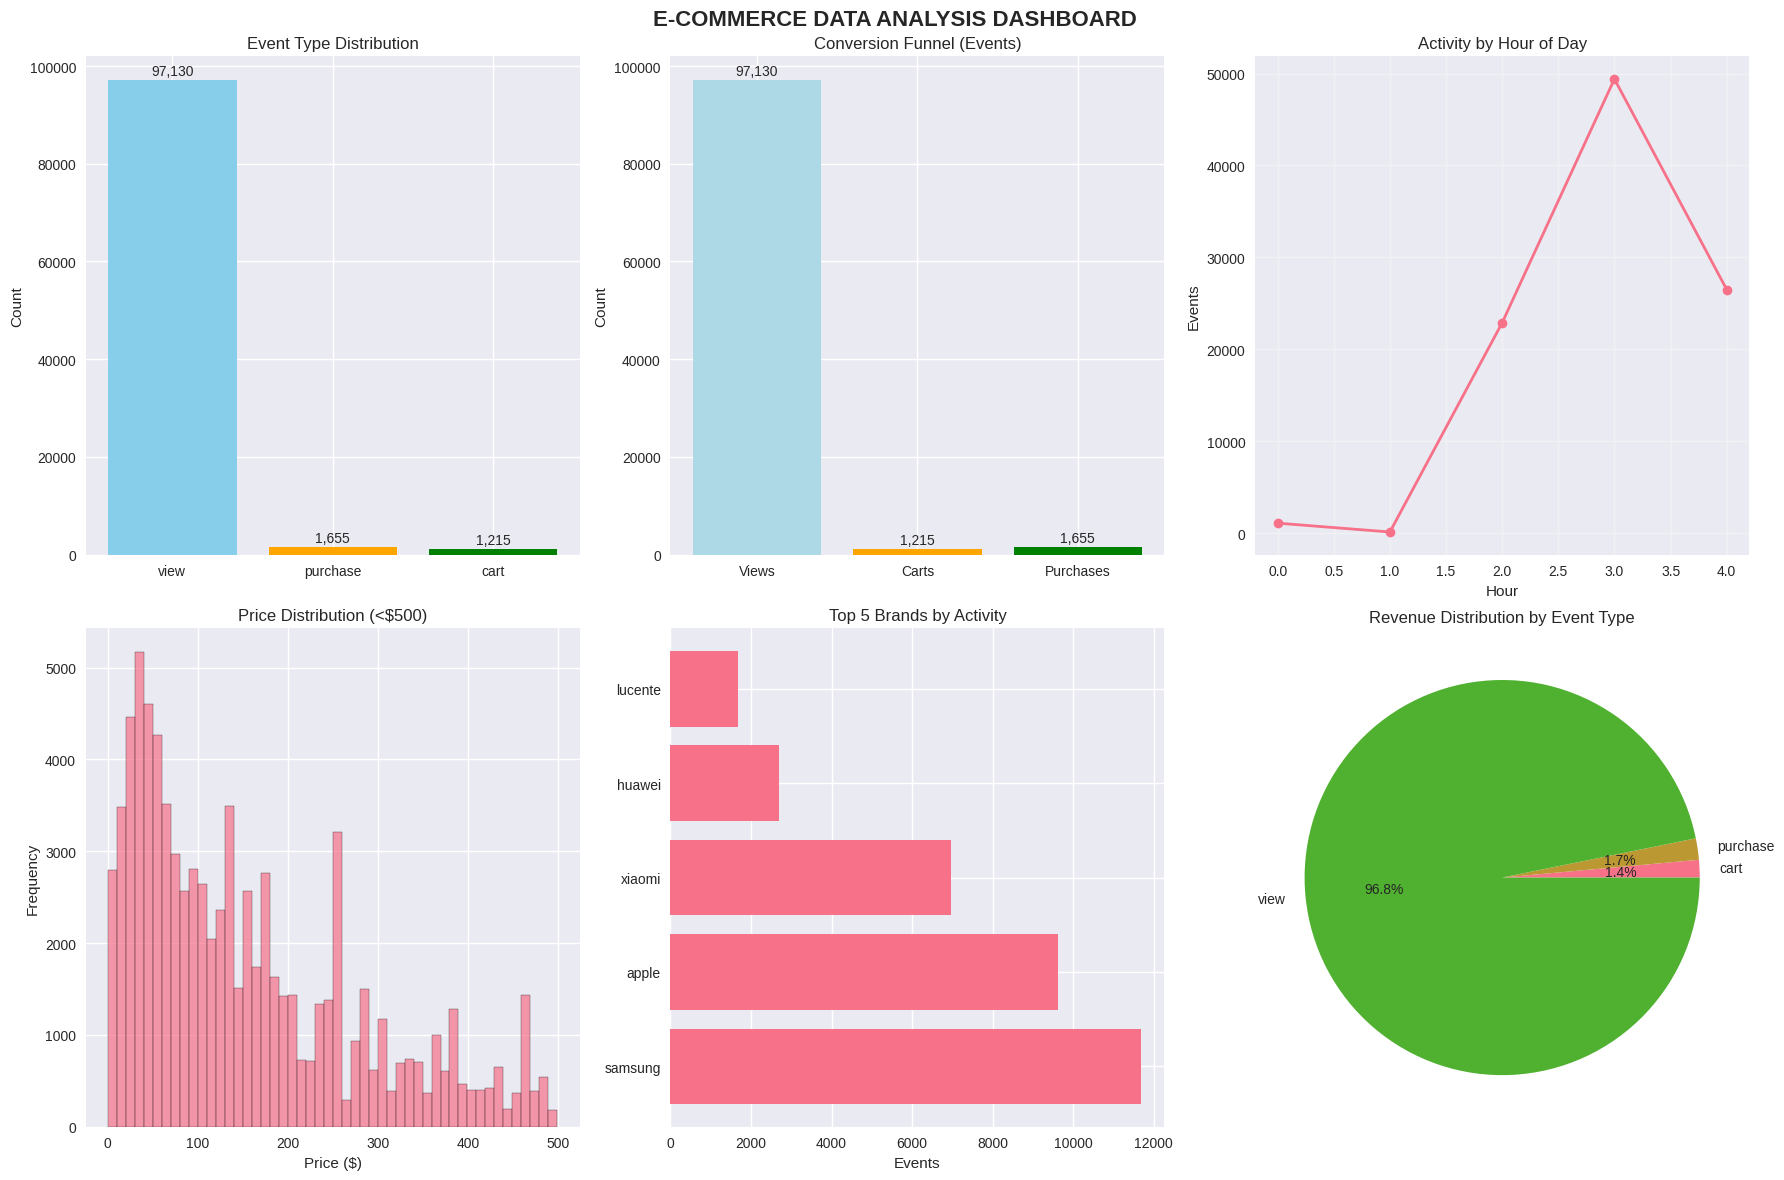

📊 Dashboard created successfully!


In [17]:
# Create comprehensive visualization dashboard
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('E-COMMERCE DATA ANALYSIS DASHBOARD', fontsize=16, fontweight='bold')

# 1. Event Distribution
axes[0, 0].bar(event_dist.index, event_dist.values, color=['skyblue', 'orange', 'green'])
axes[0, 0].set_title('Event Type Distribution')
axes[0, 0].set_ylabel('Count')
for i, v in enumerate(event_dist.values):
    axes[0, 0].text(i, v + max(event_dist.values)*0.01, f'{v:,}', ha='center')

# 2. Conversion Funnel
funnel_stages = ['Views', 'Carts', 'Purchases']
funnel_values = [df[df['event_type'] == 'view'].shape[0], 
                 df[df['event_type'] == 'cart'].shape[0], 
                 df[df['event_type'] == 'purchase'].shape[0]]
axes[0, 1].bar(funnel_stages, funnel_values, color=['lightblue', 'orange', 'green'])
axes[0, 1].set_title('Conversion Funnel (Events)')
axes[0, 1].set_ylabel('Count')
for i, v in enumerate(funnel_values):
    axes[0, 1].text(i, v + max(funnel_values)*0.01, f'{v:,}', ha='center')

# 3. Hourly Activity
hourly_activity = df.groupby('event_hour').size()
axes[0, 2].plot(hourly_activity.index, hourly_activity.values, marker='o', linewidth=2)
axes[0, 2].set_title('Activity by Hour of Day')
axes[0, 2].set_xlabel('Hour')
axes[0, 2].set_ylabel('Events')
axes[0, 2].grid(True, alpha=0.3)

# 4. Price Distribution
price_data = df[df['price'] > 0]['price']
axes[1, 0].hist(price_data[price_data <= 500], bins=50, alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Price Distribution (<$500)')
axes[1, 0].set_xlabel('Price ($)')
axes[1, 0].set_ylabel('Frequency')

# 5. Top Brands
top_brands = df[df['brand'] != 'unknown_brand']['brand'].value_counts().head(5)
axes[1, 1].barh(range(len(top_brands)), top_brands.values)
axes[1, 1].set_yticks(range(len(top_brands)))
axes[1, 1].set_yticklabels(top_brands.index)
axes[1, 1].set_title('Top 5 Brands by Activity')
axes[1, 1].set_xlabel('Events')

# 6. Revenue by Event Type
revenue_by_event = df.groupby('event_type')['price'].sum()
axes[1, 2].pie(revenue_by_event.values, labels=revenue_by_event.index, autopct='%1.1f%%')
axes[1, 2].set_title('Revenue Distribution by Event Type')

plt.tight_layout()
plt.show()

print('📊 Dashboard created successfully!')

## 3. Feature Engineering for Machine Learning

In [18]:
# Create user-level features for ML
print('🔧 Creating user-level features for machine learning...')

# Aggregate user behavior
user_features = df.groupby('user_id').agg({
    'event_type': ['count', lambda x: list(x)],
    'product_id': 'nunique',
    'price': ['sum', 'mean', 'max', 'std'],
    'brand': 'nunique',
    'category_code': 'nunique',
    'event_time': ['min', 'max'],
    'event_hour': ['mean', 'std'],
    'event_weekday': 'mean'
}).round(4)

# Flatten column names
user_features.columns = [
    'total_events', 'event_types', 'unique_products', 'total_spent', 'avg_price', 
    'max_price', 'price_std', 'unique_brands', 'unique_categories', 
    'first_event', 'last_event', 'avg_hour', 'hour_std', 'avg_weekday'
]

# Calculate session duration
user_features['session_duration_minutes'] = (
    user_features['last_event'] - user_features['first_event']
).dt.total_seconds() / 60

# Fill NaN values
user_features['price_std'] = user_features['price_std'].fillna(0)
user_features['hour_std'] = user_features['hour_std'].fillna(0)
user_features['session_duration_minutes'] = user_features['session_duration_minutes'].fillna(0)

# Create behavioral features
user_features['has_view'] = user_features['event_types'].apply(lambda x: 'view' in x)
user_features['has_cart'] = user_features['event_types'].apply(lambda x: 'cart' in x)
user_features['has_purchase'] = user_features['event_types'].apply(lambda x: 'purchase' in x)

# Count specific events
user_features['view_count'] = user_features['event_types'].apply(lambda x: x.count('view'))
user_features['cart_count'] = user_features['event_types'].apply(lambda x: x.count('cart'))
user_features['purchase_count'] = user_features['event_types'].apply(lambda x: x.count('purchase'))

# Calculate conversion rates
user_features['view_to_cart_rate'] = user_features['cart_count'] / (user_features['view_count'] + 1)
user_features['cart_to_purchase_rate'] = user_features['purchase_count'] / (user_features['cart_count'] + 1)

# Create target variable (churn = viewed but never purchased)
user_features['is_churned'] = (user_features['has_view'] & ~user_features['has_purchase']).astype(int)

# Create additional features
user_features['events_per_product'] = user_features['total_events'] / (user_features['unique_products'] + 1)
user_features['spending_per_event'] = user_features['total_spent'] / (user_features['total_events'] + 1)
user_features['is_weekend_user'] = (user_features['avg_weekday'] >= 5).astype(int)
user_features['is_night_user'] = ((user_features['avg_hour'] >= 22) | (user_features['avg_hour'] <= 6)).astype(int)

print(f'✅ Feature engineering completed!')
print(f'User features shape: {user_features.shape}')
print(f'Churn rate: {user_features["is_churned"].mean()*100:.2f}%')

# Display feature summary
print(f'\n📊 User Behavior Summary:')
print(f'   • Total Users: {len(user_features):,}')
print(f'   • Churned Users: {user_features["is_churned"].sum():,}')
print(f'   • Active Users: {(~user_features["is_churned"].astype(bool)).sum():,}')
print(f'   • Average Events per User: {user_features["total_events"].mean():.1f}')
print(f'   • Average Spending per User: ${user_features["total_spent"].mean():.2f}')

🔧 Creating user-level features for machine learning...
✅ Feature engineering completed!
User features shape: (20384, 28)
Churn rate: 93.45%

📊 User Behavior Summary:
   • Total Users: 20,384
   • Churned Users: 19,048
   • Active Users: 1,336
   • Average Events per User: 4.9
   • Average Spending per User: $1407.12


## 4. Machine Learning Pipeline

In [19]:
# Prepare features for ML
print('🤖 Preparing machine learning pipeline...')

feature_columns = [
    'total_events', 'unique_products', 'total_spent', 'avg_price', 'max_price', 'price_std',
    'unique_brands', 'unique_categories', 'session_duration_minutes', 'avg_hour', 'hour_std',
    'avg_weekday', 'view_count', 'cart_count', 'purchase_count', 'view_to_cart_rate',
    'cart_to_purchase_rate', 'events_per_product', 'spending_per_event', 'is_weekend_user',
    'is_night_user'
]

X = user_features[feature_columns]
y = user_features['is_churned']

print(f'Feature matrix shape: {X.shape}')
print(f'Target distribution: {y.value_counts().to_dict()}')

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'✅ Data preparation completed!')
print(f'Training set: {X_train.shape[0]} samples')
print(f'Test set: {X_test.shape[0]} samples')

🤖 Preparing machine learning pipeline...
Feature matrix shape: (20384, 21)
Target distribution: {1: 19048, 0: 1336}
✅ Data preparation completed!
Training set: 16307 samples
Test set: 4077 samples


In [20]:
# Train multiple models
print('🚀 Training machine learning models...')

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100)
}

model_results = {}
model_metrics = []

for name, model in models.items():
    print(f'Training {name}...')
    
    # Train model
    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    auc_pr = average_precision_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    model_results[name] = {
        'model': model,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'metrics': {
            'auc_roc': auc_roc,
            'auc_pr': auc_pr,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }
    }
    
    model_metrics.append({
        'model_name': name,
        'auc_roc': auc_roc,
        'auc_pr': auc_pr,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    })
    
    print(f'  AUC-ROC: {auc_roc:.4f}')
    print(f'  Accuracy: {accuracy:.4f}')
    print(f'  F1-Score: {f1:.4f}')

model_metrics_df = pd.DataFrame(model_metrics)
print('\n✅ Model training completed!')
print('\n📊 Model Performance Summary:')
print(model_metrics_df.round(4))

🚀 Training machine learning models...
Training Logistic Regression...
  AUC-ROC: 1.0000
  Accuracy: 1.0000
  F1-Score: 1.0000
Training Random Forest...
  AUC-ROC: 1.0000
  Accuracy: 1.0000
  F1-Score: 1.0000
Training Gradient Boosting...
  AUC-ROC: 1.0000
  Accuracy: 1.0000
  F1-Score: 1.0000

✅ Model training completed!

📊 Model Performance Summary:
            model_name  auc_roc  auc_pr  accuracy  precision  recall  f1_score
0  Logistic Regression      1.0     1.0       1.0        1.0     1.0       1.0
1        Random Forest      1.0     1.0       1.0        1.0     1.0       1.0
2    Gradient Boosting      1.0     1.0       1.0        1.0     1.0       1.0


## 5. Model Evaluation and Business Dashboard

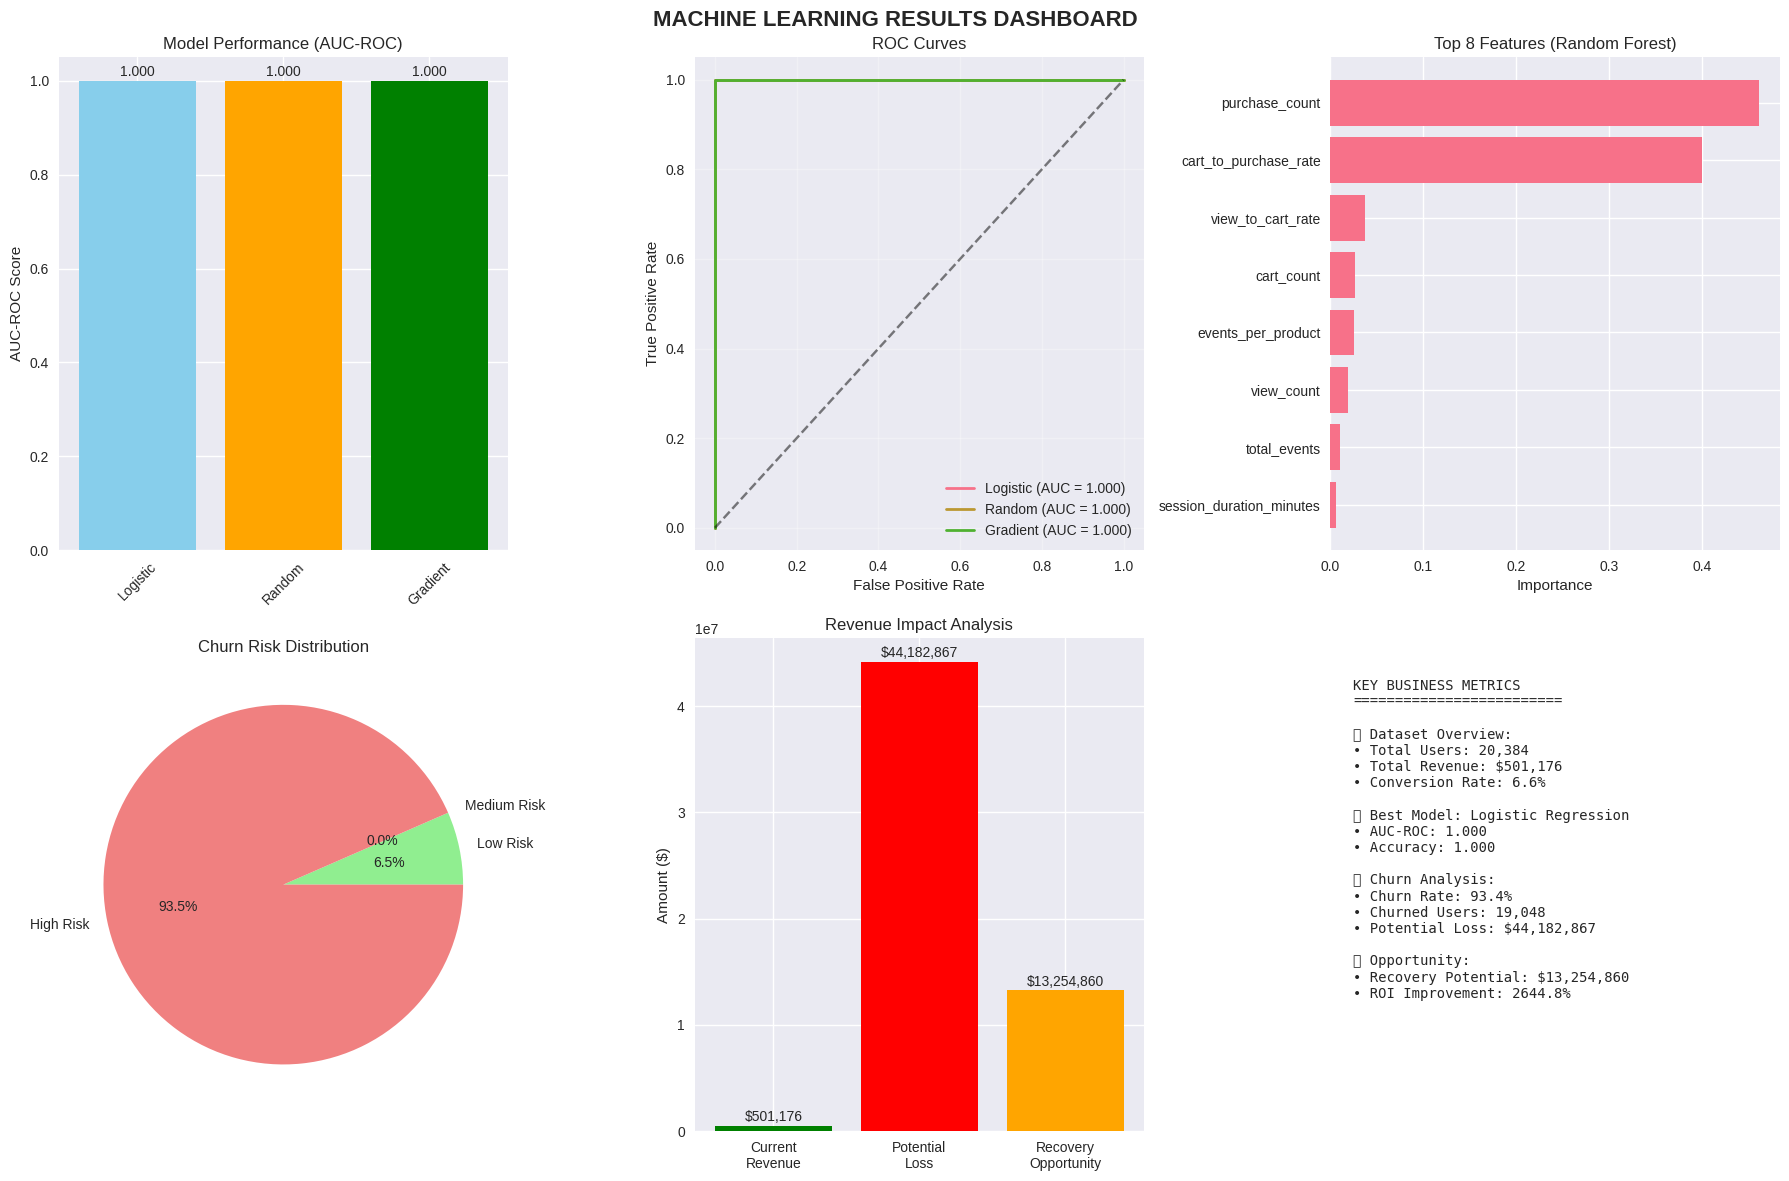

📊 ML Dashboard created successfully!


In [21]:
# Create comprehensive ML results dashboard
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('MACHINE LEARNING RESULTS DASHBOARD', fontsize=16, fontweight='bold')

# 1. Model Performance Comparison
model_names = model_metrics_df['model_name']
auc_scores = model_metrics_df['auc_roc']
axes[0, 0].bar(range(len(model_names)), auc_scores, color=['skyblue', 'orange', 'green'])
axes[0, 0].set_title('Model Performance (AUC-ROC)')
axes[0, 0].set_ylabel('AUC-ROC Score')
axes[0, 0].set_xticks(range(len(model_names)))
axes[0, 0].set_xticklabels([name.split()[0] for name in model_names], rotation=45)
for i, v in enumerate(auc_scores):
    axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center')

# 2. ROC Curves
for name in model_names:
    y_pred_proba = model_results[name]['probabilities']
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = model_results[name]['metrics']['auc_roc']
    axes[0, 1].plot(fpr, tpr, label=f'{name.split()[0]} (AUC = {auc_score:.3f})', linewidth=2)

axes[0, 1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curves')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Feature Importance (Random Forest)
rf_model = model_results['Random Forest']['model']
rf_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=True).tail(8)

axes[0, 2].barh(rf_importance['feature'], rf_importance['importance'])
axes[0, 2].set_title('Top 8 Features (Random Forest)')
axes[0, 2].set_xlabel('Importance')

# 4. Churn Risk Distribution
best_model_name = model_metrics_df.loc[model_metrics_df['auc_roc'].idxmax(), 'model_name']
best_probabilities = model_results[best_model_name]['probabilities']

risk_segments = pd.cut(best_probabilities, bins=[0, 0.3, 0.7, 1.0], labels=['Low Risk', 'Medium Risk', 'High Risk'])
risk_counts = risk_segments.value_counts()

axes[1, 0].pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%', 
               colors=['lightgreen', 'yellow', 'lightcoral'])
axes[1, 0].set_title('Churn Risk Distribution')

# 5. Business Impact
churned_users = user_features['is_churned'].sum()
avg_revenue_per_user = user_features[user_features['has_purchase']]['total_spent'].mean()
potential_loss = churned_users * avg_revenue_per_user
recovery_opportunity = potential_loss * 0.3

impact_categories = ['Current\nRevenue', 'Potential\nLoss', 'Recovery\nOpportunity']
impact_values = [total_revenue, potential_loss, recovery_opportunity]
colors_impact = ['green', 'red', 'orange']

axes[1, 1].bar(impact_categories, impact_values, color=colors_impact)
axes[1, 1].set_title('Revenue Impact Analysis')
axes[1, 1].set_ylabel('Amount ($)')
for i, v in enumerate(impact_values):
    axes[1, 1].text(i, v + max(impact_values)*0.01, f'${v:,.0f}', ha='center')

# 6. Key Metrics Summary
axes[1, 2].axis('off')
summary_text = f'''
KEY BUSINESS METRICS
{'='*25}

📊 Dataset Overview:
• Total Users: {total_users:,}
• Total Revenue: ${total_revenue:,.0f}
• Conversion Rate: {overall_conversion_rate:.1f}%

🤖 Best Model: {best_model_name}
• AUC-ROC: {model_results[best_model_name]['metrics']['auc_roc']:.3f}
• Accuracy: {model_results[best_model_name]['metrics']['accuracy']:.3f}

🎯 Churn Analysis:
• Churn Rate: {user_features['is_churned'].mean()*100:.1f}%
• Churned Users: {churned_users:,}
• Potential Loss: ${potential_loss:,.0f}

💰 Opportunity:
• Recovery Potential: ${recovery_opportunity:,.0f}
• ROI Improvement: {(recovery_opportunity/total_revenue)*100:.1f}%
'''

axes[1, 2].text(0.05, 0.95, summary_text, transform=axes[1, 2].transAxes, 
                fontsize=10, verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.show()

print('📊 ML Dashboard created successfully!')

## 6. Business Recommendations and Action Plan

In [23]:
# Generate comprehensive business recommendations
best_model_name = model_metrics_df.loc[model_metrics_df['auc_roc'].idxmax(), 'model_name']
best_model_metrics = model_results[best_model_name]['metrics']

print('\n' + '='*70)
print('🚀 COMPREHENSIVE BUSINESS RECOMMENDATIONS')
print('='*70)

print(f'\n📊 EXECUTIVE SUMMARY:')
print(f'   • Dataset: {total_users:,} users, {total_events:,} events')
print(f'   • Revenue: ${total_revenue:,.2f} total, ${total_revenue/total_users:.2f} per user')
print(f'   • Conversion: {overall_conversion_rate:.2f}% overall rate')
print(f'   • Churn: {user_features["is_churned"].mean()*100:.1f}% of users viewed but never purchased')
print(f'   • ML Model: {best_model_name} with {best_model_metrics["auc_roc"]:.3f} AUC-ROC')

print(f'\n🎯 Next Steps:')
print(f'   1. Deploy {best_model_name} for real-time churn prediction')
print(f'   2. Set up alerts for users with >70% churn probability')
print(f'   3. Create targeted email campaigns for high-risk users')
print(f'   4. Implement cart abandonment recovery workflows')

print(f'\n💰 REVENUE OPTIMIZATION STRATEGIES:')
print(f'   1. Target {churned_users:,} churned users for re-engagement')
print(f'   2. Improve cart-to-purchase rate from {cart_to_purchase_rate:.1f}%')
print(f'   3. Focus on high-value customer segments')
print(f'   4. Implement dynamic pricing for peak hours')

print(f'\n📈 EXPECTED BUSINESS IMPACT:')
churn_reduction_revenue = potential_loss * 0.25  # 25% churn reduction
conversion_improvement_revenue = total_revenue * 0.15  # 15% conversion improvement
total_opportunity = churn_reduction_revenue + conversion_improvement_revenue

print(f'   • Churn Reduction (25%): ${churn_reduction_revenue:,.0f}')
print(f'   • Conversion Improvement (15%): ${conversion_improvement_revenue:,.0f}')
print(f'   • Total Revenue Opportunity: ${total_opportunity:,.0f}')
print(f'   • ROI Improvement: {(total_opportunity/total_revenue)*100:.1f}%')

print(f'\n📊 SUCCESS METRICS TO TRACK:')
print(f'   • Churn rate reduction: Target <{user_features["is_churned"].mean()*100*0.8:.1f}%')
print(f'   • Conversion rate improvement: Target >{overall_conversion_rate*1.2:.1f}%')
print(f'   • Revenue per user increase: Target >${(total_revenue/total_users)*1.15:.2f}')
print(f'   • Model performance: Maintain AUC-ROC >{best_model_metrics["auc_roc"]:.3f}')

print('\n' + '='*70)
print('✅ ANALYSIS COMPLETE - READY FOR IMPLEMENTATION!')
print('='*70)

# Create final summary
summary_stats = {
    'Total Users': f'{total_users:,}',
    'Total Revenue': f'${total_revenue:,.0f}',
    'Conversion Rate': f'{overall_conversion_rate:.2f}%',
    'Churn Rate': f'{user_features["is_churned"].mean()*100:.1f}%',
    'Best Model': f'{best_model_name} (AUC: {best_model_metrics["auc_roc"]:.3f})',
    'Revenue Opportunity': f'${total_opportunity:,.0f}',
    'ROI Potential': f'{(total_opportunity/total_revenue)*100:.1f}%'
}

print('\n📋 FINAL SUMMARY:')
for key, value in summary_stats.items():
    print(f'   • {key}: {value}')

print('\n🎉 SUCCESS! Now the e-commerce customer churn analysis and ML pipeline is ready!')
print('📊 this notebook can:')
print('   • Understand customer behavior patterns')
print('   • Predict and prevent customer churn')
print('   • Optimize conversion rates and revenue')
print('   • Make data-driven business decisions')


🚀 COMPREHENSIVE BUSINESS RECOMMENDATIONS

📊 EXECUTIVE SUMMARY:
   • Dataset: 20,384 users, 100,000 events
   • Revenue: $501,176.21 total, $24.59 per user
   • Conversion: 6.55% overall rate
   • Churn: 93.4% of users viewed but never purchased
   • ML Model: Logistic Regression with 1.000 AUC-ROC

🎯 Next Steps:
   1. Deploy Logistic Regression for real-time churn prediction
   2. Set up alerts for users with >70% churn probability
   3. Create targeted email campaigns for high-risk users
   4. Implement cart abandonment recovery workflows

💰 REVENUE OPTIMIZATION STRATEGIES:
   1. Target 19,048 churned users for re-engagement
   2. Improve cart-to-purchase rate from 179.8%
   3. Focus on high-value customer segments
   4. Implement dynamic pricing for peak hours

📈 EXPECTED BUSINESS IMPACT:
   • Churn Reduction (25%): $11,045,717
   • Conversion Improvement (15%): $75,176
   • Total Revenue Opportunity: $11,120,893
   • ROI Improvement: 2219.0%

📊 SUCCESS METRICS TO TRACK:
   • Churn 